# Product Sales Forecasting: SARIMAX

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [ ]:
path = '/content/drive/MyDrive/Product Sales Forecasting/data/'

# Get train and test data using 'date' as the index
train = pd.read_csv(f'{path}train.csv', index_col='date', parse_dates=True)
test = pd.read_csv(f'{path}test.csv', index_col='date', parse_dates=True)

# Get list of closed days for test data
test_closed_days = test[test['closed_day'] == 1].index

In [ ]:
train.describe()

,qty,year,month,week,day_of_week,day_of_month,week_of_month,is_weekend,is_holiday,closed_day,...,lag_41_mean_3,lag_42_mean_7,lag_42_mean_14,lag_42_mean_30,lag_42_mean_60,lag_48_mean_3,lag_49_mean_7,lag_49_mean_14,lag_49_mean_30,lag_49_mean_60
count,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,...,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000
mean,6.278283,2021.232828,6.253030,25.439899,3.001515,15.712121,2.697980,0.285859,0.033333,0.005556,...,6.266667,6.259307,6.257359,6.247778,6.231785,6.256566,6.255411,6.250000,6.238636,6.224773
std,4.474715,1.578287,3.464848,15.126949,1.999873,8.807925,1.269495,0.451937,0.179551,0.074347,...,3.109215,2.364297,2.021503,1.717732,1.491842,3.109000,2.365005,2.024248,1.723780,1.497150
min,0.000000,2019.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.333333,1.571429,2.000000,2.600000,3.200000,0.333333,1.571429,2.000000,2.600000,3.200000
25%,3.000000,2020.000000,3.000000,12.000000,1.000000,8.000000,2.000000,0.000000,0.000000,0.000000,...,4.000000,4.714286,4.857143,5.033333,4.866667,4.000000,4.714286,4.839286,5.000000,4.866667
50%,6.000000,2021.000000,6.000000,24.000000,3.000000,16.000000,3.000000,0.000000,0.000000,0.000000,...,6.000000,6.000000,6.142857,6.200000,6.383333,6.000000,6.000000,6.142857,6.200000,6.383333
75%,9.000000,2023.000000,9.000000,39.000000,5.000000,23.000000,4.000000,1.000000,0.000000,0.000000,...,8.000000,7.428571,7.357143,7.266667,7.516667,8.000000,7.428571,7.357143,7.266667,7.516667
max,36.000000,2024.000000,12.000000,53.000000,6.000000,31.000000,5.000000,1.000000,1.000000,1.000000,...,26.333333,19.000000,14.428571,11.066667,9.050000,26.333333,19.000000,14.428571,11.066667,9.050000


In [ ]:
#@title Check Stationarity

from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary (p_value < 0.05)' if p_value < 0.05 else 'Non-Stationary (p_value >= 0.05)')

check_stationarity(train['qty'])

ADF Statistic: -5.917215029725114
p-value: 2.5559943142259436e-07
Stationary (p_value < 0.05)


In [ ]:
def evaluate_preds(y, y_pred, label):
    '''
        Return RMSE, MAE, and sMAPE scores
        y, y_pred, and label may be tuples of same length for evaluation on
        multiple sets
    '''

    # Compute sMAPE
    def smape_score(y_true, y_pred):
      denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
      diff = np.abs(y_pred - y_true)
      mask = denominator != 0 # Avoid division by zero
      smape_val = np.mean(diff[mask] / denominator[mask]) * 100
      return smape_val

    trues = y if isinstance(y, (tuple)) else (y,)
    preds = y_pred if isinstance(y_pred, (tuple)) else (y_pred,)

    rmse = []
    mae = []
    smape = []

    for true, pred in zip(trues, preds):
      rmse.append(round(root_mean_squared_error(true, pred), 4))
      mae.append(round(mean_absolute_error(true, pred), 4))
      smape.append(round(smape_score(true, pred), 4))

    scores = pd.DataFrame({'RMSE': rmse, 'MAE': mae, 'sMAPE': smape})
    scores.index = label if isinstance(label, (tuple)) else (label,)

    return(scores)

## SARIMA Model (no exogenous variables)

In [ ]:
# Returns test set forecast and train/test scores
def rolling_cv(train, test, params, include_exog=False, label=''):
  fitteds = []
  forecasts = []
  train_scores = []
  test_scores = []

  for i in range(0, 364, 28):
    train_fold = pd.concat([train, test[:i]]).asfreq('D')
    test_fold = test[i:i + 28]

    if include_exog:
      exog_train = train_fold.drop('qty', axis=1)
      exog_test = test_fold.drop('qty', axis=1)
    else:
      exog_train = exog_test = None

    mod = SARIMAX(
      train_fold['qty'],
      exog_train,
      order=params['order'],
      seasonal_order=params['seasonal_order']
    ).fit()

    fitted = mod.fittedvalues
    forecast = mod.forecast(28, exog=exog_test)

    # Set forecasts for closed days (i.e. Christmas, New Year's Day) to 0
    forecast.loc[test_fold.index.isin(test_closed_days)] = 0

    fitteds.append(fitted)
    forecasts.append(forecast)
    train_scores.append(evaluate_preds(train_fold['qty'], fitted, f'Fold {i / 28}'))
    test_scores.append(evaluate_preds(test_fold['qty'], forecast, f'Fold {i / 28}'))

  train_scores = pd.concat(train_scores).mean().round(4).to_frame().T
  test_scores = pd.concat(test_scores).mean().round(4).to_frame().T
  train_scores.index = [f"{label} Train Scores"]
  test_scores.index = [f"{label} Test Scores"]

  return pd.concat(forecasts), pd.concat([train_scores, test_scores])

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress specific SARIMAX warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
# Grid Search for SARIMA
'''
results = []
hw_train = train[:-364]
hw_val = train[-364:]

for p, q, P, Q in itertools.product([1, 2], [1, 2], [1], [2]):
  result = {
    'order': (p, 0, q), # d = 0 because stationary, according to ADF test
    'seasonal_order': (P, 1, Q, 7), # weekly seasonality
  }
  forecast, scores = rolling_cv(hw_train, hw_val, result)

  result['avg_rmse'] = round(float(scores.iloc[1]['RMSE']), 4)
  results.append(result)
  print(result)

results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df['avg_rmse'].idxmin()]
print("\nBest model by Average RMSE:")
print(best_model)
'''

'\nresults = []\nhw_train = train[:-364]\nhw_val = train[-364:]\n\nfor p, q, P, Q in itertools.product([1, 2], [1, 2], [1], [2]):\n  result = {\n    \'order\': (p, 0, q), # d = 0 because stationary, according to ADF test\n    \'seasonal_order\': (P, 1, Q, 7), # weekly seasonality\n  }\n  forecast, scores = rolling_cv(hw_train, hw_val, result)\n\n  result[\'avg_rmse\'] = round(float(scores.iloc[1][\'RMSE\']), 4)\n  results.append(result)\n  print(result)\n\nresults_df = pd.DataFrame(results)\nbest_model = results_df.loc[results_df[\'avg_rmse\'].idxmin()]\nprint("\nBest model by Average RMSE:")\nprint(best_model)\n'

In [ ]:
# Plot forecast
def plot_forecast(forecast, title):
  plt.figure(figsize=(16, 4))
  train.iloc[-364:]['qty'].plot(label='Train')
  test['qty'].plot(label='Actual')
  forecast.plot(label='Forecast')
  for i in range(0, test.shape[0], 28):
    plt.axvline(x=test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)
  plt.title(title)
  plt.legend()
  plt.show()

,RMSE,MAE,sMAPE
SARIMA (no exog) Train Scores,4.0697,3.080,56.8486
SARIMA (no exog) Test Scores,3.9146,3.122,65.8885


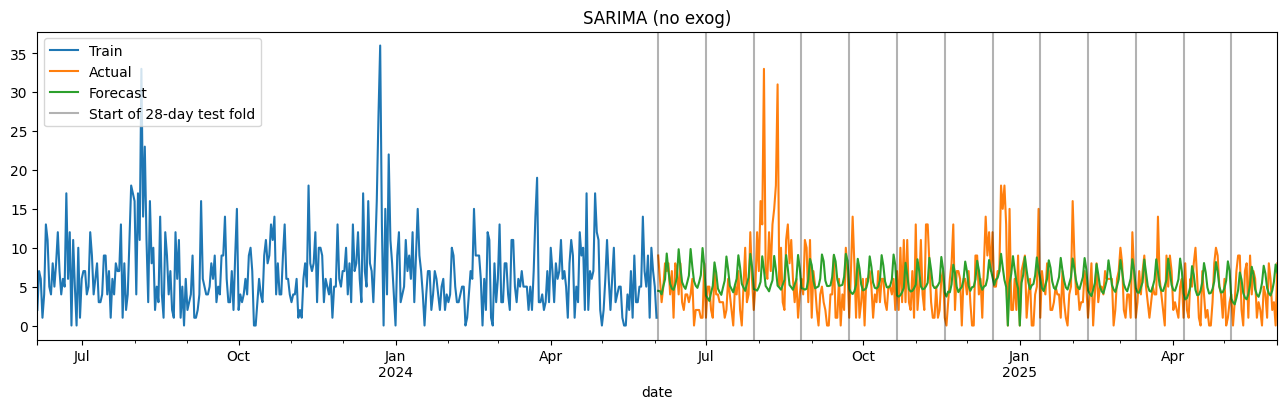

In [ ]:
# Fit model with best parameters
params = {
  'order': (2, 0, 1),
  'seasonal_order': (1, 1, 2, 7)
}

forecast_sarima, scores_sarima = rolling_cv(train, test, params, label='SARIMA (no exog)')
display(scores_sarima)
plot_forecast(forecast_sarima, 'SARIMA (no exog)')

In [ ]:
# Fit model on training dataset, get the time to fit the model, and print summary statistics

start_time = time.time()

mod = SARIMAX(
  train['qty'].asfreq('D'),
  order=(2, 0, 1),
  seasonal_order=(1, 1, 2, 7)
).fit()

print(f"Fit time: {round(time.time() - start_time, 2)} seconds")

mod.summary()

Fit time: 19.59 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    qty   No. Observations:                 1980
Model:             SARIMAX(2, 0, 1)x(1, 1, [1, 2], 7)   Log Likelihood               -5561.123
Date:                                Sun, 15 Jun 2025   AIC                          11136.246
Time:                                        21:17:33   BIC                          11175.357
Sample:                                    01-01-2019   HQIC                         11150.617
                                         - 06-02-2024                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9540      0.052     18.404      0.000       0.852       1.056
ar.L2         -0.0487      0.026     -1.865      0.062      -0.100       0.002
ma.L1         -0.8062      0.046    -17.525      0.000      -0.896      -0.716
ar.S.L7       -0.4740      0.578     -0.820      0.412      -1.606       0.658
ma.S.L7       -0.4723      0.570     -0.829      0.407      -1.589       0.644
ma.S.L14      -0.4846      0.552     -0.878      0.380      -1.566       0.597
sigma2        16.2743      0.391     41.614      0.000      15.508      17.041
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               614.39
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX Model (with exogenous variables)

In [ ]:
cols = ['qty', 'back_to_school', '6d_to_christmas', 'lag_363_mean_3']

In [ ]:
# Grid Search for SARIMAX
'''
results = []
hw_train = train[:-364][cols]
hw_val = train[-364:][cols]

for p, q, P, Q in itertools.product([1, 2], [1, 2], [1], [2]):
  result = {
    'order': (p, 0, q), # d = 0 because stationary, according to ADF test
    'seasonal_order': (P, 1, Q, 7), # weekly seasonality
  }
  forecast, scores = rolling_cv(hw_train, hw_val, result)

  result['avg_rmse'] = round(float(scores.iloc[1]['RMSE']), 4)
  results.append(result)
  print(result)

results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df['avg_rmse'].idxmin()]
print("\nBest model by Average RMSE:")
print(best_model)
'''

'\nresults = []\nhw_train = train[:-364][cols]\nhw_val = train[-364:][cols]\n\nfor p, q, P, Q in itertools.product([1, 2], [1, 2], [1], [2]):\n  result = {\n    \'order\': (p, 0, q), # d = 0 because stationary, according to ADF test\n    \'seasonal_order\': (P, 1, Q, 7), # weekly seasonality\n  }\n  forecast, scores = rolling_cv(hw_train, hw_val, result)\n\n  result[\'avg_rmse\'] = round(float(scores.iloc[1][\'RMSE\']), 4)\n  results.append(result)\n  print(result)\n\nresults_df = pd.DataFrame(results)\nbest_model = results_df.loc[results_df[\'avg_rmse\'].idxmin()]\nprint("\nBest model by Average RMSE:")\nprint(best_model)\n'

,RMSE,MAE,sMAPE
SARIMAX (with exog) Train Scores,3.9232,3.0166,56.5426
SARIMAX (with exog) Test Scores,3.7024,2.9481,63.9775
SARIMA (no exog) Train Scores,4.0697,3.0800,56.8486
SARIMA (no exog) Test Scores,3.9146,3.1220,65.8885


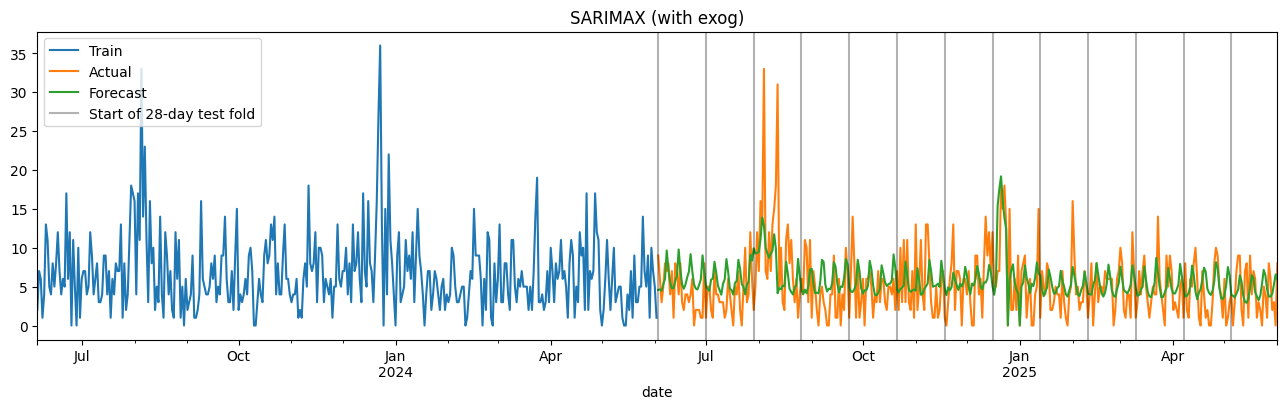

In [ ]:
params = {
  'order': (2, 0, 1),
  'seasonal_order': (1, 1, 2, 7)
}

forecast_sarimax, scores_sarimax = rolling_cv(train[cols], test[cols], params, include_exog=True, label='SARIMAX (with exog)')
display(pd.concat([scores_sarimax, scores_sarima]))
plot_forecast(forecast_sarimax, 'SARIMAX (with exog)')

In [ ]:
# Fit model on training dataset, get the time to fit the model, and print summary statistics

train_copy = train[cols].copy().asfreq('D')

start_time = time.time()

mod = SARIMAX(
  train_copy['qty'],
  train_copy.drop('qty', axis=1),
  order=(2, 0, 1),
  seasonal_order=(1, 1, 2, 7)
).fit()

print(f"Fit time: {round(time.time() - start_time, 2)} seconds")

mod.summary()

Fit time: 32.0 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    qty   No. Observations:                 1980
Model:             SARIMAX(2, 0, 1)x(1, 1, [1, 2], 7)   Log Likelihood               -5482.672
Date:                                Sun, 15 Jun 2025   AIC                          10985.345
Time:                                        22:04:03   BIC                          11041.218
Sample:                                    01-01-2019   HQIC                         11005.874
                                         - 06-02-2024                                         
Covariance Type:                                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
back_to_school      3.6681      0.405      9.062      0.000       2.875       4.462
6d_to_christmas     8.3451      0.523     15.961      0.000       7.320       9.370
lag_363_mean_3      0.1632      0.035      4.660      0.000       0.095       0.232
ar.L1              -0.4152      0.917     -0.453      0.651      -2.213       1.383
ar.L2               0.0529      0.063      0.840      0.401      -0.071       0.176
ma.L1               0.4890      0.919      0.532      0.595      -1.312       2.290
ar.S.L7            -0.5524      0.702     -0.787      0.431      -1.928       0.823
ma.S.L7            -0.3842      0.692     -0.555      0.579      -1.741       0.973
ma.S.L14           -0.5440      0.659     -0.826      0.409      -1.835       0.747
sigma2             15.0421      0.384     39.151      0.000      14.289      15.795
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               343.61
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

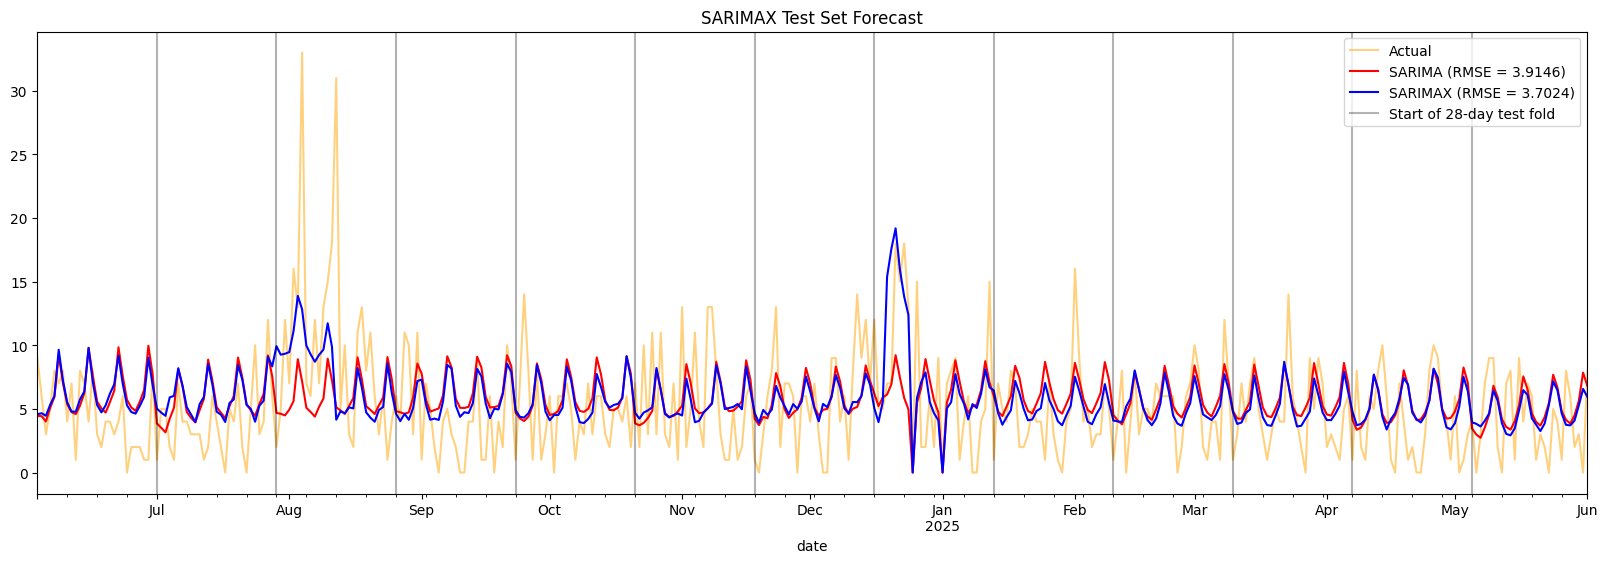

In [ ]:
plt.figure(figsize=(20, 6))
test['qty'].plot(label='Actual', alpha=0.5, color='orange')
forecast_sarima.plot(label=f"SARIMA (RMSE = {scores_sarima.iloc[1]['RMSE']})", color='red')
forecast_sarimax.plot(label=f"SARIMAX (RMSE = {scores_sarimax.iloc[1]['RMSE']})", color='blue')
for i in range(0, test.shape[0], 28):
  plt.axvline(x=test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)

plt.title(f'SARIMAX Test Set Forecast')
plt.legend()
plt.show()

## Residual Analysis

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

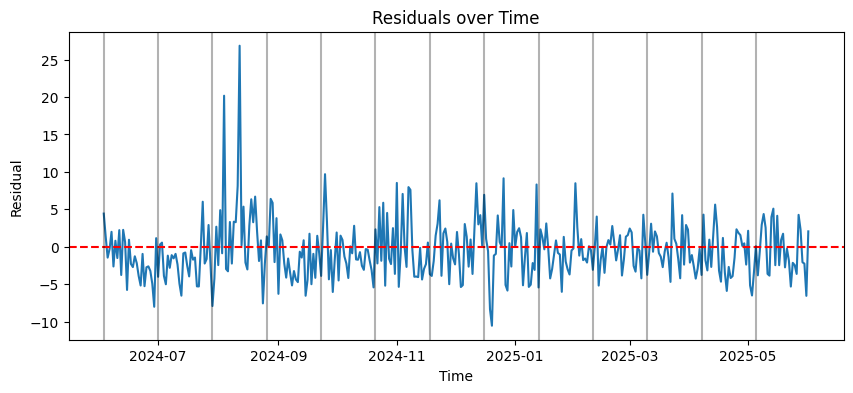

In [ ]:
residuals = test['qty'] - forecast_sarimax

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, linestyle='--', color='red')
for i in range(0, test.shape[0], 28):
  plt.axvline(x=test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)
plt.show()

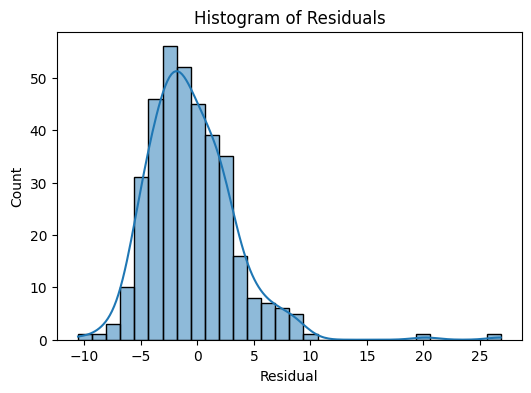

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.show()

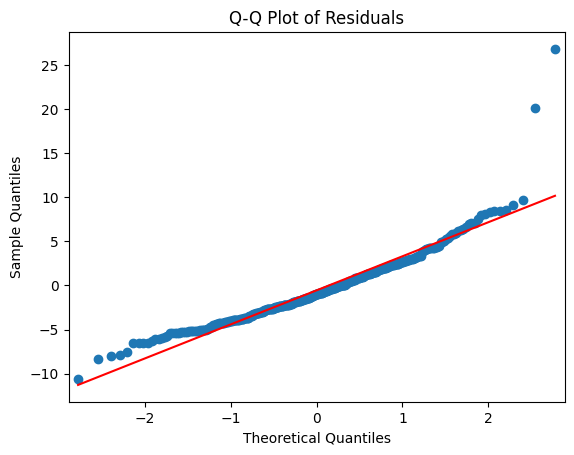

In [ ]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

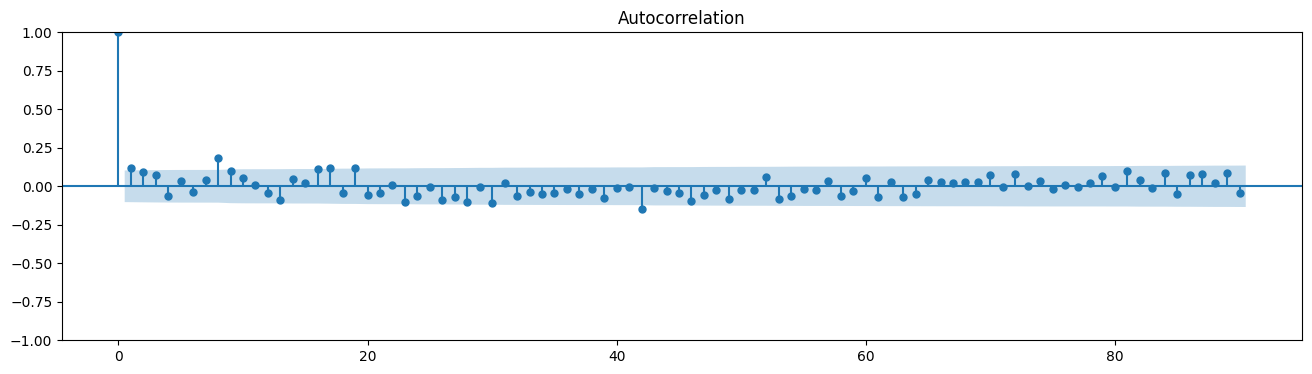

In [ ]:
plot_acf(residuals, lags=90).set_size_inches(16, 4)
plt.show()

In [ ]:
acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)

,lb_stat,lb_pvalue
10,30.696066,0.000659
20,52.742855,0.000089
30,72.950664,0.000019


In [ ]:
#@title Export Best Test Forecasts to CSV File

best_forecast = forecast_sarimax.rename('forecast')
best_forecast.to_csv(f'{path}forecast_sarimax.csv', index=True, index_label='date')